### Hash function performance check

#### common libs

In [119]:
import time, hashlib

#### init helper

In [ ]:
import random
import string

def random_string(length=10):
    letters = string.ascii_letters + string.digits
    return ''.join(random.choices(letters, k=length))

def random_id():
    part1 = random_string(8)
    part2 = random_string(4)
    part3 = random_string(4)
    part4 = random_string(4)
    part5 = random_string(12)
    return f"{part1}-{part2}-{part3}-{part4}-{part5}"

#### common vars

In [160]:
NIDs = 15_000
NRPT = 60

In [232]:
import threading, psutil, queue, statistics

INTV = 1

def check_cpu_util(q):
    cpu = psutil.Process()
    utils = []
    until = 0
    inc, nrpt = (int(INTV*10), NRPT*10) if INTV < 1 else (INTV, NRPT)
    while until < nrpt:
        utils.append(cpu.cpu_percent(interval=INTV))
        until += inc
    q.put(utils)


#### pure random ids

In [233]:
start_time = time.time()

q = queue.Queue()
cpu_checker = threading.Thread(target=check_cpu_util, args=(q,))
cpu_checker.start()
for _ in range(NRPT):
    tkick = time.time()
    [random_id() for _ in range(NIDs)]
    telapse = time.time() - tkick
    if (1 - telapse) > 0:
        time.sleep(1 - telapse)

cpu_checker.join()

end_time = time.time()
etime_pure = end_time - start_time
print(f"Time taken to generate random IDs: {etime_pure:.4f} seconds")
utils_pure = q.get()
mx_pure = max(utils_pure)
avg_pure = statistics.mean(utils_pure)
print(f"Maximum CPU utilization: {mx_pure:.4f}%")
print(f"Average CPU utilization: {avg_pure:.4f}%")

Time taken to generate random IDs: 60.2849 seconds
Maximum CPU utilization: 7.7000%
Average CPU utilization: 6.9917%


#### hashed ids

In [234]:
def md5_hash(text):
    return hashlib.md5(text.encode()).hexdigest()

start_time = time.time()
q = queue.Queue()
cpu_checker = threading.Thread(target=check_cpu_util, args=(q, ))
cpu_checker.start()
for _ in range(NRPT):
    tkick = time.time()
    [md5_hash(random_id()) for _ in range(NIDs)]
    [md5_hash(random_id()) for _ in range(NIDs)]
    telapse = time.time() - tkick
    if (1 - telapse) > 0:
        time.sleep(1 - telapse)

cpu_checker.join()

end_time = time.time()
etime_hash = end_time - start_time
print(f"Time taken to hash random IDs: {etime_hash:.4f} seconds")
utils_hash = q.get()
mx_hash = max(utils_hash)
avg_hash = statistics.mean(utils_hash)
print(f"Maximum CPU utilization: {mx_hash:.4f}%")
print(f"Average CPU utilization: {avg_hash:.4f}%")

Time taken to hash random IDs: 60.4245 seconds
Maximum CPU utilization: 14.6000%
Average CPU utilization: 13.1750%


#### check the diff

In [235]:
diff = (mx_hash - mx_pure) * 100 / mx_pure if mx_pure > 0 else 0
print(f"MD5 CPU max overhead: {diff:.2f}%")

diff = (avg_hash - avg_pure) * 100 / avg_pure if avg_pure > 0 else 0
print(f"MD5 CPU avg overhead: {diff:.2f}%")


MD5 CPU max overhead: 89.61%
MD5 CPU avg overhead: 88.44%


### Plot

In [165]:
pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


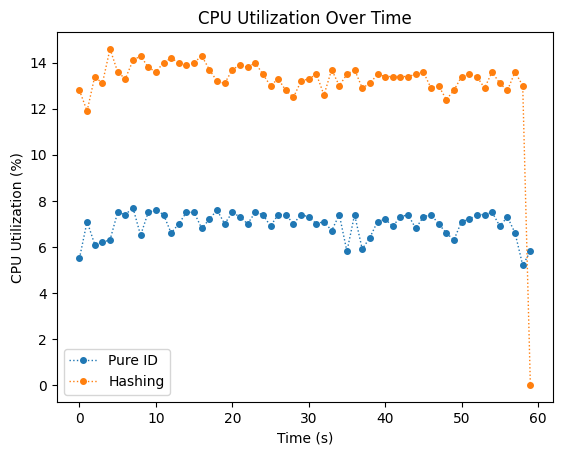

In [239]:
import matplotlib.pyplot as plt

x = range(0, int(NRPT/INTV))

plt.plot(x, utils_pure, label='Pure ID', marker='o', markersize=4, linewidth=1, linestyle=':')
plt.plot(x, utils_hash, label='Hashing', marker='o', markersize=4, linewidth=1, linestyle=':')
plt.xlabel('Time (s)')
plt.ylabel('CPU Utilization (%)')
plt.title('CPU Utilization Over Time')
plt.legend()
plt.show()